In [7]:
!pip install flatbuffers
!pip install protobuf==3.20.0
!pip install pyttsx3;
!pip install pandas
!pip install tensorflow

  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.5.0 requires absl-py~=0.10, but you have absl-py 1.1.0 which is incompatible.
tensorflow-gpu 2.5.0 requires flatbuffers~=1.12.0, but you have flatbuffers 23.5.26 which is incompatible.
tensorflow-gpu 2.5.0 requires numpy~=1.19.2, but you have numpy 1.21.0 which is incompatible.
tensorflow-gpu 2.5.0 requires tensorflow-estimator<2.6.0,>=2.5.0rc0, but you have tensorflow-estimator 2.9.0 which is incompatible.
tensorflow-gpu 2.5.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.5.0 which is incompatible.
tensorflow 2.9.1 requires flatbuffers<2,>=1.12, but you have flatbuffers 23.5.26 which is incompatible.
tensorflow 2.9.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.0 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To up

  Using cached protobuf-3.20.0-cp310-cp310-win_amd64.whl (903 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.4
    Uninstalling protobuf-4.23.4:
      Successfully uninstalled protobuf-4.23.4


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.0 which is incompatible.


  Using cached protobuf-4.23.4-cp310-abi3-win_amd64.whl (422 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.0
    Uninstalling protobuf-3.20.0:
      Successfully uninstalled protobuf-3.20.0


In [8]:
import win32com.client
import pyttsx3;
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input

In [9]:
#Class that actually executes the commands to retrieve email information
class Command():
    def __init__(self):
        outlook = win32com.client.Dispatch('outlook.application')
        self.mapi = outlook.GetNamespace("MAPI")
        
    def readLastInboxMessage(self):
        inbox = self.mapi.GetDefaultFolder(6)
        messages = inbox.Items
        message = messages.GetLast()
        return message.Body
    
    def readLastInboxSubject(self):
        inbox = self.mapi.GetDefaultFolder(6)
        messages = inbox.Items
        message = messages.GetLast()
        return message.Subject

    def getAttachmentofLastEmail(self):
        inbox = self.mapi.GetDefaultFolder(6)
        messages = inbox.Items
        message = messages.GetLast()
        return message.Attachments  
    
    def execute(self, commandType):
        if commandType == 1:
            return self.readLastInboxMessage()
        elif commandType == 2:
            return self.readLastInboxSubject()
        else:
            return None

In [10]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary = True) #Loads in pretrained word2vec model

In [11]:
model.most_similar("file")#Test to check what most similar words are

[('files', 0.7133817076683044),
 ('filing', 0.647048830986023),
 ('filed', 0.5737501382827759),
 ('refile', 0.5691325664520264),
 ('Rod_Aydelotte_photo', 0.5590430498123169),
 ('File', 0.5576274991035461),
 ('fi_le', 0.551184892654419),
 ('Image_###K_GIF', 0.5502156019210815),
 ('Filing', 0.5267105102539062),
 ('Image_##K_GIF', 0.5109704732894897)]

In [18]:
#Gets and reshapes all the data from the dataset to be in the correct format for the NN
colnames = ["input","label"]
ds = pd.read_csv('synthetic_training_data.csv', usecols = colnames)
with open("stoplist.txt", "r") as F:
    stoplist = F.read()
    clean = []
for i in range(0, len(ds["input"])):
    clean.append([word for word in ds["input"][i].split() if word not in stoplist])

x_train = np.array([])
zero = np.zeros(shape = (1,300))

for i in range(0, len(ds["input"])):
    sentence = clean[i]
    vec = np.array([])
    for j in range(0,len(sentence)):
        word = model[sentence[j]]
        vec = np.append(vec, word)
    vec = vec.reshape(j+1,300)
    for k in range(j,19):
        vec = np.append(vec, zero)
    vec = np.array(vec)
    vec = vec.reshape(20,300)
    x_train = np.append(x_train, vec)
x_train = x_train.reshape(len(ds["input"]),20, 300)
print(x_train.shape)

(1120, 20, 300)


In [19]:
num_classes = 3
temp = ds["label"]
y_train = []
for i in temp:
    current = [0] * num_classes
    current[i-1] = 1
    y_train.append(current)

y_train = np.array(y_train, dtype = int)
print(y_train.shape)

(1120, 3)


In [20]:
#Creating the Neural NEtwork
nnmodel = keras.Sequential()
nnmodel.add(keras.layers.InputLayer(input_shape = (20, 300)))
nnmodel.add(keras.layers.Flatten())
nnmodel.add(keras.layers.Dropout(0.1))
nnmodel.add(keras.layers.Dense(units = 2000, activation = "relu"))
nnmodel.add(keras.layers.Dropout(0.1))
nnmodel.add(keras.layers.Dense(units = 1600, activation = "relu"))
nnmodel.add(keras.layers.Dense(units = 100, activation = "relu"))
nnmodel.add(keras.layers.Dense(units = 100, activation = "relu"))
nnmodel.add(keras.layers.Dense(units = 20, activation = "relu"))
nnmodel.add(keras.layers.Dense(units = num_classes, activation = "softmax"))

optim = tf.keras.optimizers.Adam(learning_rate = 0.00001)

nnmodel.compile(optim, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
nnmodel.save_weights('model.h5')
history = nnmodel.fit(x_train, y_train, epochs=30, batch_size = 64)

Epoch 1/30
18/18 [==============================] - 1s 52ms/step - loss: 1.0938 - accuracy: 0.4348
Epoch 2/30
18/18 [==============================] - 1s 52ms/step - loss: 1.0754 - accuracy: 0.6830
Epoch 3/30
18/18 [==============================] - 1s 51ms/step - loss: 1.0496 - accuracy: 0.7482
Epoch 4/30
18/18 [==============================] - 1s 51ms/step - loss: 1.0103 - accuracy: 0.8348
Epoch 5/30
18/18 [==============================] - 1s 51ms/step - loss: 0.9583 - accuracy: 0.8580
Epoch 6/30
18/18 [==============================] - 1s 53ms/step - loss: 0.8968 - accuracy: 0.8813
Epoch 7/30
18/18 [==============================] - 1s 52ms/step - loss: 0.8235 - accuracy: 0.9045
Epoch 8/30
18/18 [==============================] - 1s 53ms/step - loss: 0.7410 - accuracy: 0.9223
Epoch 9/30
18/18 [==============================] - 1s 51ms/step - loss: 0.6516 - accuracy: 0.9429
Epoch 10/30
18/18 [==============================] - 1s 52ms/step - loss: 0.5621 - accuracy: 0.9527
Epoch 11/

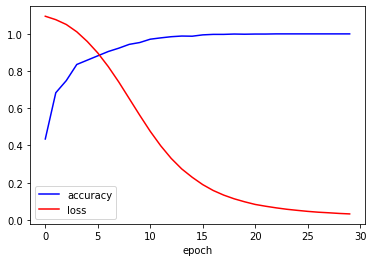

In [21]:
#All Loss-Accuracy Graphs
plt.plot(history.history['accuracy'], color = 'b')
plt.plot(history.history['loss'], color = 'r')
plt.xlabel('epoch')
plt.legend(['accuracy','loss'])
plt.show()

In [51]:
#nnmodel.evaluate(x=x_valid, y=y_valid) 

11/11 [==============================] - 0s 8ms/step - loss: 0.0044 - accuracy: 1.0000


[0.0044215028174221516, 1.0]

In [22]:
#Gets the test set into the correct format
colnames = ["input","label"]
ds = pd.read_csv('synthetic_testing_data.csv', usecols = colnames)
#ds = pd.read_csv('synthetic_testing_data.csv', usecols = colnames)
with open("stoplist.txt", "r") as F:
    stoplist = F.read()
    clean = []
for i in range(0, len(ds["input"])):
    clean.append([word for word in ds["input"][i].split() if word not in stoplist])

x_test = np.array([])
zero = np.zeros(shape = (1,300))

for i in range(0, len(ds["input"])):
    sentence = clean[i]
    vec = np.array([])
    for j in range(0,len(sentence)):
        word = model[sentence[j]]
        vec = np.append(vec, word)
    vec = vec.reshape(j+1,300)
    for k in range(j,19):
        vec = np.append(vec, zero)
    vec = np.array(vec)
    vec = vec.reshape(20,300)
    x_test = np.append(x_test, vec)
x_test = x_test.reshape(len(ds["input"]),20, 300)
print(x_test.shape)

(1600, 20, 300)


In [23]:
num_classes = 3
temp = ds["label"]
y_test = []
for i in temp:
    current = [0] * num_classes
    current[i-1] = 1
    y_test.append(current)

y_test = np.array(y_test, dtype = int)
print(y_test.shape)

(1600, 3)


In [24]:
#Evaluates the model against the test set 
nnmodel.evaluate(x=x_test, y=y_test)

50/50 [==============================] - 1s 8ms/step - loss: 0.9598 - accuracy: 0.6781


[0.9598449468612671, 0.6781250238418579]

Epoch 1/20
18/18 [==============================] - 1s 52ms/step - loss: 0.4487 - accuracy: 0.8268
Epoch 2/20
18/18 [==============================] - 1s 51ms/step - loss: 0.0552 - accuracy: 0.9857
Epoch 3/20
18/18 [==============================] - 1s 50ms/step - loss: 0.0147 - accuracy: 0.9964
Epoch 4/20
18/18 [==============================] - 1s 51ms/step - loss: 0.0103 - accuracy: 0.9973
Epoch 5/20
18/18 [==============================] - 1s 51ms/step - loss: 0.0205 - accuracy: 0.9946
Epoch 6/20
18/18 [==============================] - 1s 52ms/step - loss: 0.0109 - accuracy: 0.9964
Epoch 7/20
18/18 [==============================] - 1s 51ms/step - loss: 0.0089 - accuracy: 0.9973
Epoch 8/20
18/18 [==============================] - 1s 54ms/step - loss: 0.0190 - accuracy: 0.9929
Epoch 9/20
18/18 [==============================] - 1s 54ms/step - loss: 0.0078 - accuracy: 0.9982
Epoch 10/20
18/18 [==============================] - 1s 51ms/step - loss: 0.0041 - accuracy: 0.9991
Epoch 11/

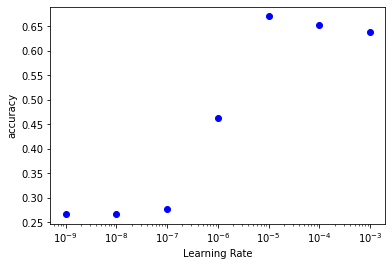

In [28]:
#ignore this - used for generated results and graphs
for i in range(3,10):
    nnmodel.load_weights('model.h5')
    lr = 1 * pow(10,-i)
    optim = tf.keras.optimizers.Adam(learning_rate = lr)
    nnmodel.compile(optim, loss='categorical_crossentropy', metrics=['accuracy'])
    history = nnmodel.fit(x_train, y_train, epochs=20, batch_size = 64)
    plt.plot(lr, float(nnmodel.evaluate(x=x_test, y=y_test)[1]), 'bo')
plt.xlabel('Learning Rate')
plt.xscale("log")
plt.ylabel('accuracy')
plt.plot()
plt.show()

In [53]:
#an in depth look at the model's class predictions in the testing set
ar = nnmodel.predict(x=x_test)
excelnumber = 2
for i in ar:
    print(excelnumber, ": ",i.tolist().index(max(i)) + 1)
    excelnumber +=1
    

2 :  1
3 :  1
4 :  1
5 :  1
6 :  1
7 :  1
8 :  1
9 :  1
10 :  1
11 :  1
12 :  1
13 :  1
14 :  1
15 :  1
16 :  1
17 :  1
18 :  2
19 :  2
20 :  1
21 :  1
22 :  2
23 :  3
24 :  3
25 :  2
26 :  3
27 :  2
28 :  2
29 :  2
30 :  2
31 :  2
32 :  3
33 :  3
34 :  2
35 :  1
36 :  1
37 :  3
38 :  3
39 :  3
40 :  2
41 :  2
42 :  3
43 :  3
44 :  1
45 :  3
46 :  1


In [97]:
#Executes the email command using any given sentence. YOU MUST USE REAL WORDS
sentence = "return the topic"
clean = []
clean = [word for word in sentence.split() if word not in stoplist]
print(clean)
vec = np.array([])
for j in range(0,len(clean)):
    word = model[clean[j]]
    vec = np.append(vec, word)
vec = vec.reshape(j+1,300)
for k in range(j,19):
    vec = np.append(vec, zero)
vec = np.array(vec)
vec = vec.reshape(1, 20, 300)

ar = np.array(nnmodel.predict(vec))
print(ar)
classnum =  np.argmax(ar) + 1
print("Class Number: " , classnum)

emailController = Command()
print("Email Output: ")
emailController.execute(classnum)

['return', 'topic']
[[0.9146363  0.08253296 0.00283068]]
Class Number:  1
Email Output: 


' <https://www.amazon.co.uk/gp/r.html?C=2X8R0PK3LTH9J&K=2VP7D0BP8A0BL&M=urn:rtn:msg:202109121417186c0d06d28b354a68ad32e78e0050p0eu&R=340RO1NFOP1LW&T=O&U=https%3A%2F%2Fimages-eu.ssl-images-amazon.com%2Fimages%2FG%2F01%2Fnav%2Ftransp.gif&H=U4QVULOGULK3AB5YEICIRZGOQGEA&ref_=pe_27063361_487055811_opens> \r\n <https://www.amazon.co.uk/gp/r.html?C=2X8R0PK3LTH9J&K=2VP7D0BP8A0BL&M=urn:rtn:msg:202109121417186c0d06d28b354a68ad32e78e0050p0eu&R=2EZIWFJLF2IF4&T=C&U=https%3A%2F%2Fwww.amazon.co.uk%2Fref%3Dpe_27063361_487055811_TE_g_i&H=DZDLP9956CATGLSA9VJP6YAAFDKA&ref_=pe_27063361_487055811_TE_g_i> \t Your Orders <https://www.amazon.co.uk/gp/r.html?C=2X8R0PK3LTH9J&K=2VP7D0BP8A0BL&M=urn:rtn:msg:202109121417186c0d06d28b354a68ad32e78e0050p0eu&R=1KMD1S1SLE9AY&T=C&U=https%3A%2F%2Fwww.amazon.co.uk%2Fgp%2Fcss%2Fyour-orders-access%2Fref%3Dpe_27063361_487055811_TE_oh_tn&H=2G4AUARB2VHP4ZHPTCA67MT76FMA&ref_=pe_27063361_487055811_TE_oh_tn>  \t  |   \tYour Account <https://www.amazon.co.uk/gp/f.html?C=2X8R0PK3LTH